# BIG DATA ANALYSIS - UK AMAZON PRODUCTS

## With Pyspark

In [1]:
# Importing the necessary libraries 
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType
from pyspark.sql.functions import col, sum, countDistinct, count, regexp_replace, split, month, year, size, element_at, struct, trim, avg, expr, lit
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("AmazonBestSellers") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/06 22:33:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Define the schema
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("title", StringType(), True),
    StructField("imgUrl", StringType(), True),
    StructField("productURL", StringType(), True),
    StructField("stars", DoubleType(), True),
    StructField("reviews", IntegerType(), True),
    StructField("price", StringType(), True),
    StructField("isBestSeller", StringType(), True),
    StructField("boughtInLastMonth", IntegerType(), True),
    StructField("categoryName", StringType(), True),
])

In [4]:
# Define the file path
file_path = '../amazon-products/amz_uk_processed_data.csv'

# Start the timer
start_time = time.time()

# Read the CSV file into a DataFrame
df = spark.read.csv(file_path, schema=schema, header=True, quote='"', escape='"')

# End the timer
end_time = time.time()

# Calculate the execution time
execution_time = end_time - start_time

# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

# Display the shape
print("Shape: {} rows and {} columns".format(num_rows, num_columns))

# Print the execution time
print("Execution Time using PySpark:", execution_time, "seconds")

Shape: 2222742 rows and 10 columns
Execution Time using PySpark: 0.744816780090332 seconds


## Inspecting the data

In [5]:
# Checking out the first rows of the dataframe
df.limit(6).toPandas()

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",https://m.media-amazon.com/images/I/71C3lbbeLs...,https://www.amazon.co.uk/dp/B09B96TG33,4.7,15308,21.99,False,0,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",https://m.media-amazon.com/images/I/61c5rSxwP0...,https://www.amazon.co.uk/dp/B01HTH3C8S,4.7,98099,23.99,True,0,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",https://m.media-amazon.com/images/I/61j3SEUjMJ...,https://www.amazon.co.uk/dp/B09B8YWXDF,4.7,15308,21.99,False,0,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",https://m.media-amazon.com/images/I/71yf6yTNWS...,https://www.amazon.co.uk/dp/B09B8T5VGV,4.7,7205,31.99,False,0,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,https://m.media-amazon.com/images/I/613dEoF9-r...,https://www.amazon.co.uk/dp/B09WX6QD65,4.6,1881,17.99,False,0,Hi-Fi Speakers
5,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",https://m.media-amazon.com/images/I/71bnkM5q8C...,https://www.amazon.co.uk/dp/B09B97WSLF,4.7,7205,31.99,False,0,Hi-Fi Speakers


In [6]:
df.limit(6).collect()

[Row(asin='B09B96TG33', title='Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | Charcoal', imgUrl='https://m.media-amazon.com/images/I/71C3lbbeLsL._AC_UL320_.jpg', productURL='https://www.amazon.co.uk/dp/B09B96TG33', stars=4.7, reviews=15308, price='21.99', isBestSeller='False', boughtInLastMonth=0, categoryName='Hi-Fi Speakers'),
 Row(asin='B01HTH3C8S', title='Anker Soundcore mini, Super-Portable Bluetooth Speaker with 15-Hour Playtime, 66-Foot Bluetooth Range, Wireless Speaker with Enhanced Bass, Noise-Cancelling Microphone, for Outdoor, Travel, Home', imgUrl='https://m.media-amazon.com/images/I/61c5rSxwP0L._AC_UL320_.jpg', productURL='https://www.amazon.co.uk/dp/B01HTH3C8S', stars=4.7, reviews=98099, price='23.99', isBestSeller='True', boughtInLastMonth=0, categoryName='Hi-Fi Speakers'),
 Row(asin='B09B8YWXDF', title='Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | De

In [7]:
# Selecting specific columns only
df.select('title', 'stars', 'reviews').limit(5).toPandas()

,title,stars,reviews
0,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308
1,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099
2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308
3,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205
4,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881


In [8]:
# Checking that the asin (Amazon Standard Identification Number) is unique
# The collect() method returns a list of rows, [0] is used to access the first row in the list, 
# and [0] again is used to access the first element (the count of distinct values) in that row.
df.agg(countDistinct("asin")).collect()[0][0]

2222742

In [9]:
# Filtering the dataframe for a specific category
df.filter(col('categoryName') == 'Baby').limit(10).toPandas()

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,B071944V6V,Baby & Toddler Happy Nappy Reusable Swim Nappy,https://m.media-amazon.com/images/I/71mNGXovFO...,https://www.amazon.co.uk/dp/B071944V6V,4.7,14311,11.0,True,200,Baby
1,B013K1WKZ8,Unisex Kids Puddle Iv All-in-One Suit,https://m.media-amazon.com/images/I/61sR4B+QqZ...,https://www.amazon.co.uk/dp/B013K1WKZ8,4.7,8821,9.95,True,100,Baby
2,B07P5H3ZFT,Warm In One Wetsuit,https://m.media-amazon.com/images/I/61mvDhsVuM...,https://www.amazon.co.uk/dp/B07P5H3ZFT,4.7,3911,24.99,False,100,Baby
3,B081H2T5PC,Athletic Crew Grip Socks - Cozy Warm Winter So...,https://m.media-amazon.com/images/I/71dsd5zDqL...,https://www.amazon.co.uk/dp/B081H2T5PC,4.6,11735,6.79,True,400,Baby
4,B00JKKHBTO,Eco by Naty Nappy Pants - Hypoallergenic and C...,https://m.media-amazon.com/images/I/811HyRRGy0...,https://www.amazon.co.uk/dp/B00JKKHBTO,4.5,3619,32.0,False,400,Baby
5,B07KRMD9T4,Little Seeds New Born Swaddle Wrap 0-3 Months ...,https://m.media-amazon.com/images/I/7152N1Mfe5...,https://www.amazon.co.uk/dp/B07KRMD9T4,4.5,7842,17.99,False,1000,Baby
6,B09QZJWDVQ,5 Pairs Baby Kids Anti-slip Socks Cotton non s...,https://m.media-amazon.com/images/I/619UErCsU6...,https://www.amazon.co.uk/dp/B09QZJWDVQ,4.7,2630,7.99,True,500,Baby
7,B0B6WBGSCZ,Yoofoss Baby Sleeping Bag 6-12 Months 100% Cot...,https://m.media-amazon.com/images/I/814mJlRdfE...,https://www.amazon.co.uk/dp/B0B6WBGSCZ,4.7,523,17.99,False,200,Baby
8,B07NB7SR71,"Love To Dream Swaddle Up Original, Small (3.5-...",https://m.media-amazon.com/images/I/610FF+Fr3j...,https://www.amazon.co.uk/dp/B07NB7SR71,4.5,18361,30.99,False,500,Baby
9,B0BP7VW84D,Unisex Cushioned Sportswear Crew 6 Pairs Crew ...,https://m.media-amazon.com/images/I/61gKYjnAmS...,https://www.amazon.co.uk/dp/B0BP7VW84D,4.7,225,23.0,True,300,Baby


In [10]:
# Filtering the dataframe for products with more than 5 images
df.filter(col('isBestSeller') == True).select('asin','stars').limit(10).toPandas()

,asin,stars
0,B01HTH3C8S,4.7
1,B09B97BPSW,4.6
2,B09B8XRZYB,4.6
3,B08L84ST93,4.6
4,B08CMJ2YZX,4.4
5,B07GBR9HG4,4.5
6,B016OC1682,4.3
7,B07W7LDV7K,4.4
8,B0BSF3JF9M,4.6
9,B0BSFKYRDM,4.6


## Keeping only columns of interest

In [11]:
cols = ['asin', 'title', 'price', 'stars', 'reviews', 'productURL', 'categoryName']

In [12]:
df = df.select(cols)

In [13]:
df.limit(6).toPandas()

,asin,title,price,stars,reviews,productURL,categoryName
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",21.99,4.7,15308,https://www.amazon.co.uk/dp/B09B96TG33,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",23.99,4.7,98099,https://www.amazon.co.uk/dp/B01HTH3C8S,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",21.99,4.7,15308,https://www.amazon.co.uk/dp/B09B8YWXDF,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",31.99,4.7,7205,https://www.amazon.co.uk/dp/B09B8T5VGV,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,17.99,4.6,1881,https://www.amazon.co.uk/dp/B09WX6QD65,Hi-Fi Speakers
5,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",31.99,4.7,7205,https://www.amazon.co.uk/dp/B09B97WSLF,Hi-Fi Speakers


## Counting null values

In [14]:
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Display the null counts
null_counts.toPandas()

,asin,title,price,stars,reviews,productURL,categoryName
0,0,0,0,0,0,0,0


In [15]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- productURL: string (nullable = true)
 |-- categoryName: string (nullable = true)



## Cleaning and transforming the final_price column

In [16]:
# Double check that there's definitely no missing values in the final_price column
df.filter(col("price").isNull()).count()

0

In [17]:
# Remove the $ sign from the final_price column and change the data type from string to double
df = df.withColumn("price", col("price").cast('double'))

In [18]:
# Check the schema
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- productURL: string (nullable = true)
 |-- categoryName: string (nullable = true)



In [19]:
pd.options.display.max_colwidth = None

## Inspecting category column

In [20]:
df.select('title', 'stars', 'categoryName').limit(5).toPandas()

,title,stars,categoryName
0,"Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | Charcoal",4.7,Hi-Fi Speakers
1,"Anker Soundcore mini, Super-Portable Bluetooth Speaker with 15-Hour Playtime, 66-Foot Bluetooth Range, Wireless Speaker with Enhanced Bass, Noise-Cancelling Microphone, for Outdoor, Travel, Home",4.7,Hi-Fi Speakers
2,"Echo Dot (5th generation, 2022 release) | Big vibrant sound Wi-Fi and Bluetooth smart speaker with Alexa | Deep Sea Blue",4.7,Hi-Fi Speakers
3,"Echo Dot with clock (5th generation, 2022 release) | Bigger vibrant sound Wi-Fi and Bluetooth smart speaker and Alexa | Cloud Blue",4.7,Hi-Fi Speakers
4,Introducing Echo Pop | Full sound compact Wi-Fi and Bluetooth smart speaker with Alexa | Charcoal,4.6,Hi-Fi Speakers


In [21]:
# Count the distinct values in the category column
(df.groupBy('categoryName').count()).count()

296

# Which product categories have the most products?

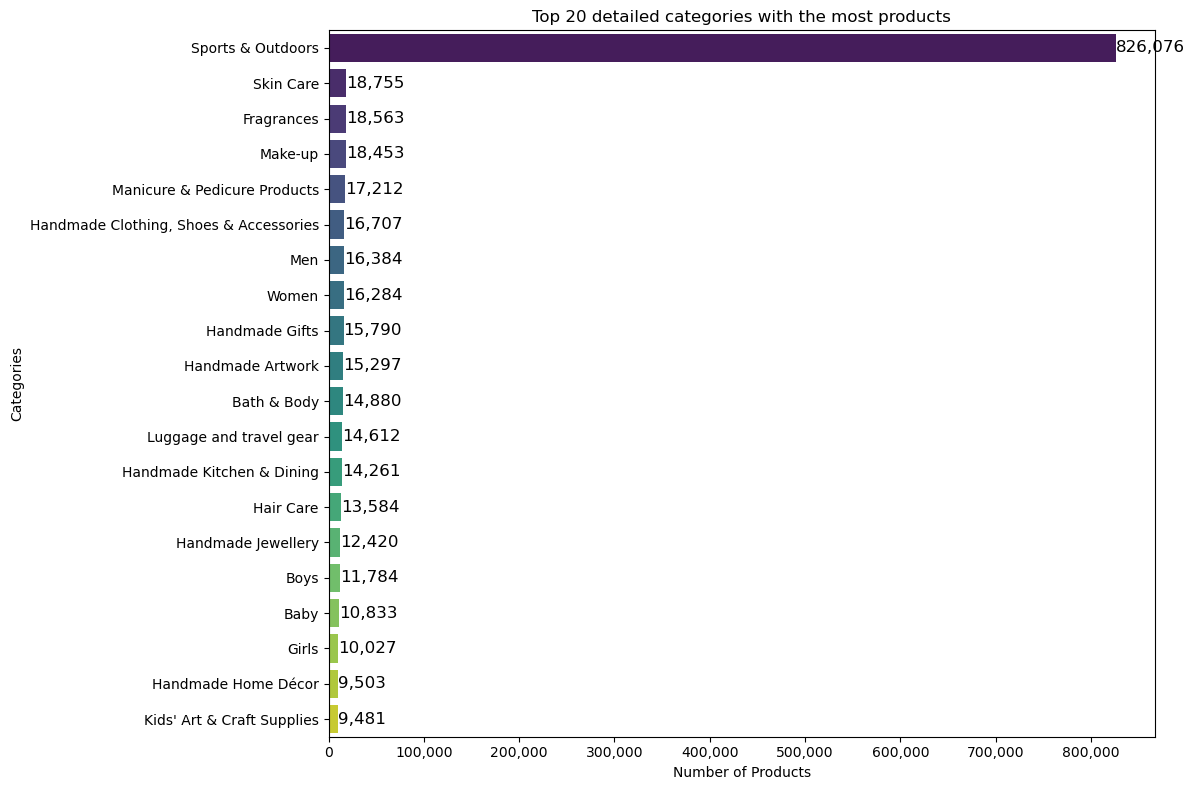

In [22]:
# Group by 'category' and count the number of rows for each category
grouped_df = df.groupBy("categoryName").agg(count("*").alias("count"))

# Order by the count in descending order and limit to the top 30 categories
top_20_df = grouped_df.orderBy(col("count").desc()).limit(20)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting with seaborn
pandas_df = top_20_df.toPandas()

# Create a horizontal bar chart using seaborn
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="count", y="categoryName", data=pandas_df, palette="viridis")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Format the data labels with a thousands comma separator and add them to the bars
for index, value in enumerate(pandas_df["count"]):
    ax.text(value, index, f"{value:,.0f}", ha='left', va='center', color='black', fontsize=12)

ax.set_xlabel("Number of Products")
ax.set_ylabel("Categories")
ax.set_title("Top 20 detailed categories with the most products")

plt.tight_layout()
plt.show()

# Analysis on a specific category: Sports and Outdoors

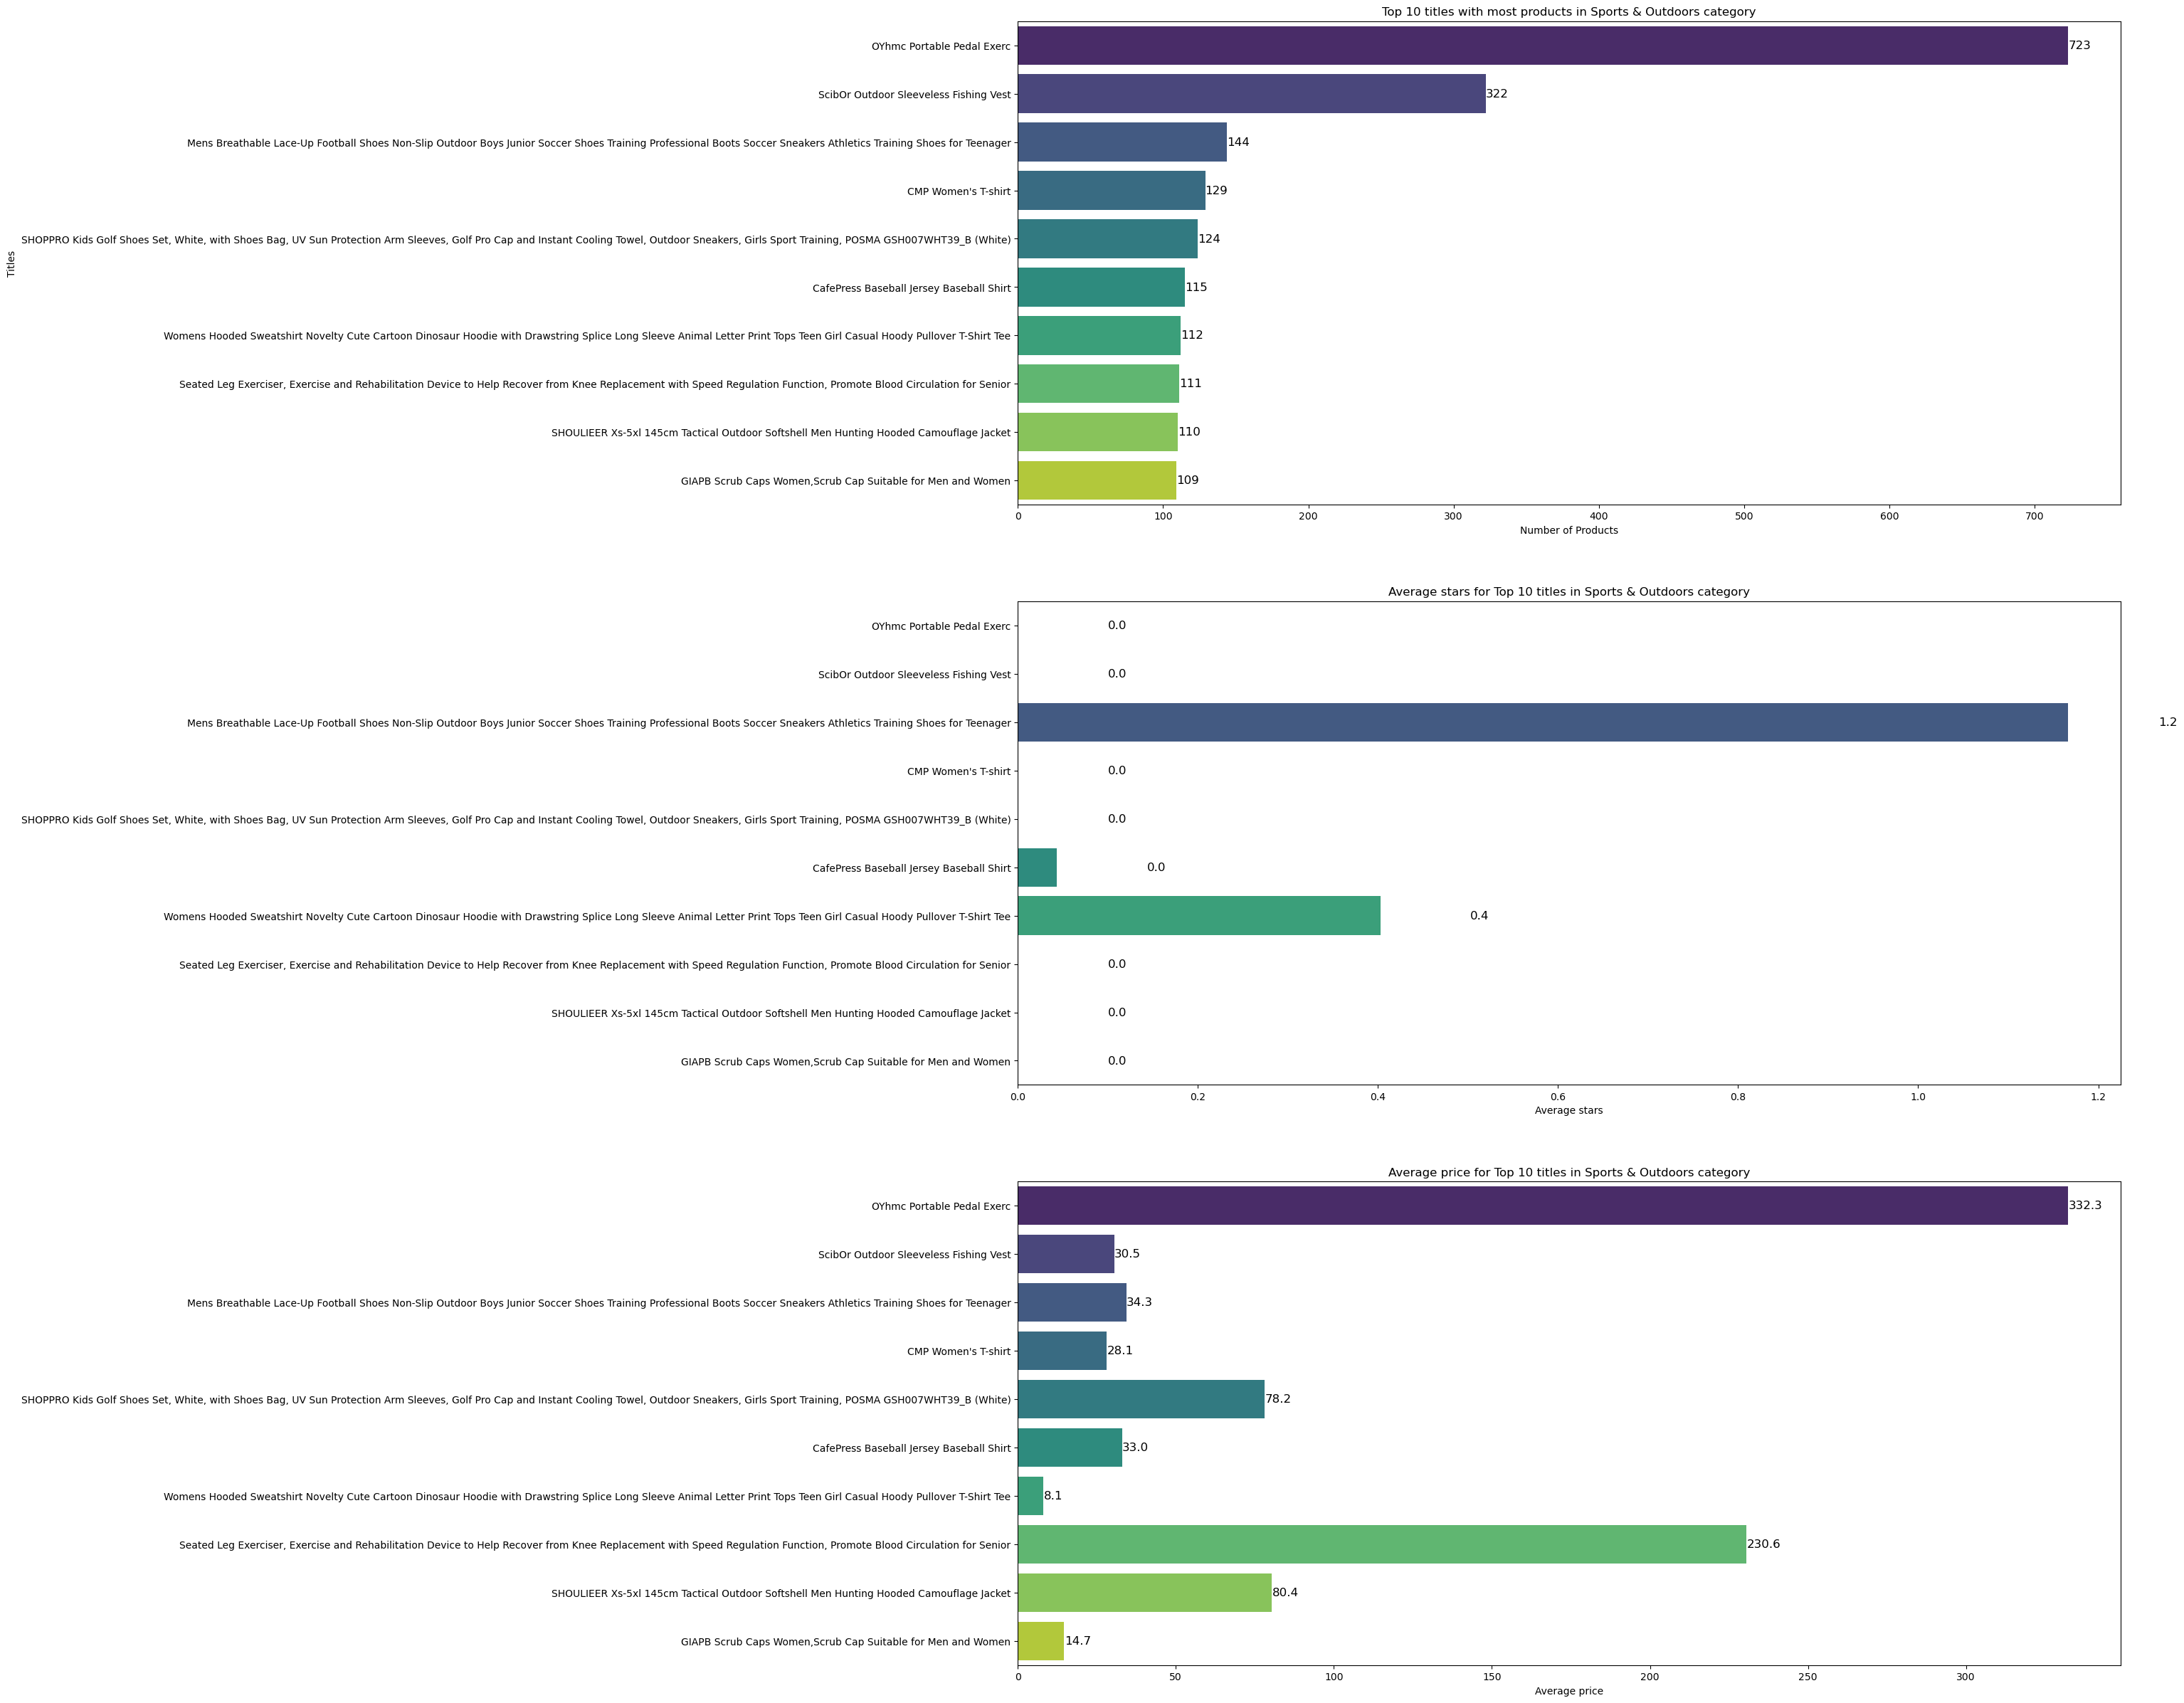

In [23]:
# Define the variables that we want to specify
det_cat = 'Sports & Outdoors'
metric1 = 'stars'
metric2 = 'price'

# Filter the DataFrame to keep only rows where 'detailed_category' is 'Cases'
filtered_df = df.filter(col("categoryName") == det_cat)

# Group by 'title' and count the number of rows for each brand
grouped_df = filtered_df.groupBy("title").agg(count("*").alias("title_count"))

# Calculate the average metric (final_price) for each product
avg_metric1_df = filtered_df.groupBy("title").agg(avg(metric1).alias("avg_metric1"))

# Calculate the average rating for each product
avg_metric2_df = filtered_df.groupBy("title").agg(avg(metric2).alias("avg_metric2"))

# Join the grouped_df, avg_metric_df, and avg_rating_df DataFrames on 'title' to combine the information
pandas_df = grouped_df.join(avg_metric1_df, on="title", how="inner").join(avg_metric2_df, on="title", how="inner").toPandas()

# Sort the DataFrame in descending order based on product count
pandas_df = pandas_df.sort_values(by="title_count", ascending=False)

# Limit the result to the top 10 products by count
pandas_df = pandas_df.head(10)

# Create a figure with three subplots
fig, axes = plt.subplots(3, figsize=(20,30))


# Plot 1
# Horizontal bar chart for brand count
sns.barplot(x="title_count", y="title", data=pandas_df, palette="viridis", ax=axes[0])

# Format the data labels for brand count
for index, value in enumerate(pandas_df["title_count"]):
    axes[0].text(value, index, f"{value:,.0f}", ha='left', va='center', color='black', fontsize=12)

# Format the x-axis labels for brand count
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

# Set labels and title for the first plot
axes[0].set_xlabel("Number of Products")
axes[0].set_ylabel("Titles")
axes[0].set_title("Top 10 titles with most products in " + det_cat + " category")


# Plot 2
# Horizontal bar chart for average metric (final_price)
sns.barplot(x="avg_metric1", y="title", data=pandas_df, palette="viridis", ax=axes[1])

# Set a small offset for the data labels
label_offset = 0.1

# Format the data labels for average metric (final_price)
for index, value in enumerate(pandas_df["avg_metric1"]):
    axes[1].text(value + label_offset, index, f"{value:.1f}", ha='left', va='center', color='black', fontsize=12)

# Set labels and title for the second plot
axes[1].set_xlabel("Average " + metric1)
axes[1].set_ylabel("")  # Hide the ylabel for the second plot
axes[1].set_title("Average " + metric1 + " for Top 10 titles in " + det_cat + " category")


# Plot 3
# Horizontal bar chart for average rating
sns.barplot(x="avg_metric2", y="title", data=pandas_df, palette="viridis", ax=axes[2])

# Format the data labels for average rating
for index, value in enumerate(pandas_df["avg_metric2"]):
    axes[2].text(value + label_offset, index, f"{value:.1f}", ha='left', va='center', color='black', fontsize=12)

# Set labels and title for the third plot
axes[2].set_xlabel("Average " + metric2)
axes[2].set_ylabel("")  # Hide the ylabel for the third plot
axes[2].set_title("Average " + metric2 + " for Top 10 titles in " + det_cat + " category")


# Adjust spacing between the subplots
# plt.tight_layout()

# Display the plots
plt.show()

## Diving deep into specific products

In [25]:
title = ['OYhmc Portable Pedal Exerc'] # expensive
# title = ['SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket'] # medium
# title = ['Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee'] # cheap

(df.filter(col("title").isin(title) & (col("categoryName") == det_cat))
              .sort(col("stars").desc())
              .limit(10)
              .toPandas())

,asin,title,price,stars,reviews,productURL,categoryName
0,B0BR7XQ75G,OYhmc Portable Pedal Exerc,137.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XQ75G,Sports & Outdoors
1,B0BR7XNZQV,OYhmc Portable Pedal Exerc,219.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XNZQV,Sports & Outdoors
2,B0BR7XNZQT,OYhmc Portable Pedal Exerc,331.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XNZQT,Sports & Outdoors
3,B0BR7XLJ3T,OYhmc Portable Pedal Exerc,567.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XLJ3T,Sports & Outdoors
4,B0BR7XLJ3B,OYhmc Portable Pedal Exerc,550.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XLJ3B,Sports & Outdoors
5,B0BR7XLCV1,OYhmc Portable Pedal Exerc,332.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XLCV1,Sports & Outdoors
6,B0BR7XDQ9M,OYhmc Portable Pedal Exerc,504.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XDQ9M,Sports & Outdoors
7,B0BR7XDQ34,OYhmc Portable Pedal Exerc,396.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XDQ34,Sports & Outdoors
8,B0BR7XDQ2T,OYhmc Portable Pedal Exerc,127.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7XDQ2T,Sports & Outdoors
9,B0BR7X98T4,OYhmc Portable Pedal Exerc,475.99,0.0,0,https://www.amazon.co.uk/dp/B0BR7X98T4,Sports & Outdoors


In [26]:
# title = ['OYhmc Portable Pedal Exerc'] # expensive
title = ['SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket'] # medium
# title = ['Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee'] # cheap

(df.filter(col("title").isin(title) & (col("categoryName") == det_cat))
              .sort(col("stars").desc())
              .limit(10)
              .toPandas())

,asin,title,price,stars,reviews,productURL,categoryName
0,B09BCRNXR7,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,79.91,0.0,0,https://www.amazon.co.uk/dp/B09BCRNXR7,Sports & Outdoors
1,B09BCRBWFX,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,78.69,0.0,0,https://www.amazon.co.uk/dp/B09BCRBWFX,Sports & Outdoors
2,B09BCR9DGL,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,79.91,0.0,0,https://www.amazon.co.uk/dp/B09BCR9DGL,Sports & Outdoors
3,B09BCR2BN9,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,79.91,0.0,0,https://www.amazon.co.uk/dp/B09BCR2BN9,Sports & Outdoors
4,B09BCR1BKT,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,79.91,0.0,0,https://www.amazon.co.uk/dp/B09BCR1BKT,Sports & Outdoors
5,B09BCQZCKH,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,79.91,0.0,0,https://www.amazon.co.uk/dp/B09BCQZCKH,Sports & Outdoors
6,B09BCQVJ1F,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,78.34,0.0,0,https://www.amazon.co.uk/dp/B09BCQVJ1F,Sports & Outdoors
7,B09BCQTNJM,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,81.99,0.0,0,https://www.amazon.co.uk/dp/B09BCQTNJM,Sports & Outdoors
8,B09BCQQ64S,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,81.99,0.0,0,https://www.amazon.co.uk/dp/B09BCQQ64S,Sports & Outdoors
9,B09BCQPPVK,SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket,81.99,0.0,0,https://www.amazon.co.uk/dp/B09BCQPPVK,Sports & Outdoors


In [27]:
# title = ['OYhmc Portable Pedal Exerc'] # expensive
# title = ['SHOULIEER Xs-5xl 145cm Tactical Outdoor Softshell Men Hunting Hooded Camouflage Jacket'] # medium
title = ['Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee'] # cheap

(df.filter(col("title").isin(title) & (col("categoryName") == det_cat))
              .sort(col("stars").desc())
              .limit(10)
              .toPandas())

,asin,title,price,stars,reviews,productURL,categoryName
0,B08GSHBBLK,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,5.0,1,https://www.amazon.co.uk/dp/B08GSHBBLK,Sports & Outdoors
1,B08GQWFZ73,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,5.0,1,https://www.amazon.co.uk/dp/B08GQWFZ73,Sports & Outdoors
2,B08GSB5PPK,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,3.98,4.0,1,https://www.amazon.co.uk/dp/B08GSB5PPK,Sports & Outdoors
3,B08GQV3XSV,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,4.0,1,https://www.amazon.co.uk/dp/B08GQV3XSV,Sports & Outdoors
4,B08GQVT288,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,3.8,3,https://www.amazon.co.uk/dp/B08GQVT288,Sports & Outdoors
5,B08GS1ZKJ2,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,3.0,1,https://www.amazon.co.uk/dp/B08GS1ZKJ2,Sports & Outdoors
6,B08GQTQLXC,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,3.0,1,https://www.amazon.co.uk/dp/B08GQTQLXC,Sports & Outdoors
7,B08GSB6NY3,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,2.9,2,https://www.amazon.co.uk/dp/B08GSB6NY3,Sports & Outdoors
8,B08GQWK6T7,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,2.4,7,https://www.amazon.co.uk/dp/B08GQWK6T7,Sports & Outdoors
9,B08GS7PGKG,Womens Hooded Sweatshirt Novelty Cute Cartoon Dinosaur Hoodie with Drawstring Splice Long Sleeve Animal Letter Print Tops Teen Girl Casual Hoody Pullover T-Shirt Tee,8.98,2.0,1,https://www.amazon.co.uk/dp/B08GS7PGKG,Sports & Outdoors
